In [1]:
import ugradio
import numpy as np
import matplotlib.pylab as plt
from scipy.stats import binned_statistic
# import pandas as pd


Error loading librtlsdr. Make sure librtlsdr (and all of its dependencies) are in your path


In [2]:
freq_0 = 1420.4058e6 # Hz
num_samples = 2048 
samp_rate = 3.2e6 # Hz
c_speed = 299792458 # m/s

In [3]:
def freq_to_period(freq):
    '''take frequency (in kHz)
    and converts to period (in microseconds)'''
    return (1/freq) * 1000

def fft(data, num_samp=2048, samp_rate=3.2e6):
    f = np.fft.fftshift(np.fft.fftfreq(num_samp, 1/samp_rate))
    Fx = np.fft.fftshift(np.fft.fft(data))
    return f, Fx

def average_power(data):
    f, Fx = fft(data)
    pwr = np.abs(Fx)**2
    avg_pwr = np.mean(pwr, axis=0)
    return f, avg_pwr

def adjust_freq_res(freqs, data, target_res):
    bins = int(samp_rate / target_res)
    bin_means, bin_edges, binnumber = binned_statistic(freqs, data, bins=bins)
    return bin_edges[:-1], bin_means


In [4]:
def freq_resolution(samp_rate, num_samples):
    result = samp_rate / num_samples
    return result

print('frequency resolution = ' + str(freq_resolution(samp_rate, 1600)) + ' [units of samp_rate]')

frequency resolution = 2000.0 [units of samp_rate]


In [5]:
def interference(data, factor=1.01):
    data = data.copy()
    for i in range(len(data) - 1):
        est = .5 * (data[i-1] + data[i+1])
        if data[i] / est > factor:
            data[i] = est
    return data

# import data

In [6]:
# pre-process data
pwd = '../data/'
fileList = ['on', 'off', 'cold', 'cal']

P = {}
target_freq_res = 2e3 # Hz

for fins in fileList:
    fname = f'{pwd}p_' + fins + '_3200.npz'
    data = np.load(fname)
    f, avg_pwr = data[data.files[0]], data[data.files[1]]
    
    # reduce freq resolution to 2000 Hz
    f, avg_pwr = adjust_freq_res(f, avg_pwr, target_freq_res)
    
    # conservative intereference removal
    avg_pwr = interference(avg_pwr, factor=1.01)
    
    P[fins] = [f, avg_pwr]

# plot data

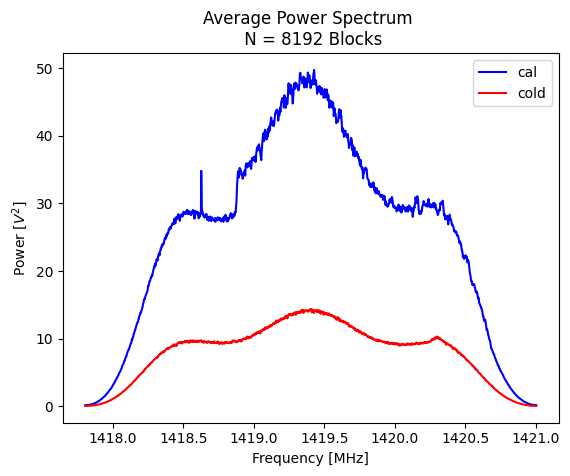

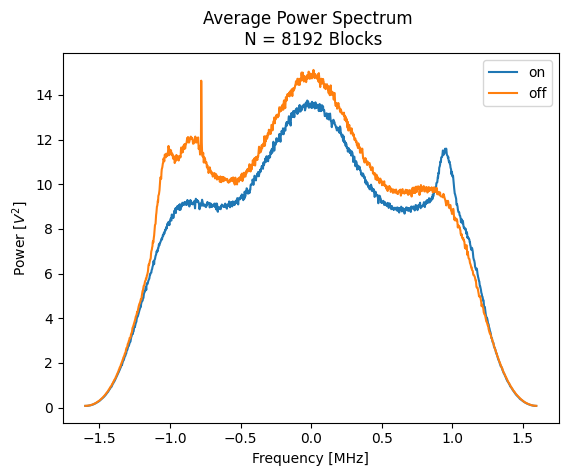

In [7]:
def plot_avg_power():
    
    plt.figure()
    
    # cal
    name = 'cal'
    f, pwr = P[name]
    plt.plot((f + freq_0) * 10**-6 - 1, pwr, label=name, color='b')
    
    # cold
    name = 'cold'
    f, pwr = P[name]
    plt.plot((f + freq_0) * 10**-6 - 1, pwr, label=name, color='r')
    
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('Power [$V^2$]')
    plt.title('Average Power Spectrum \n N = ' + '8192' + ' Blocks')
    plt.legend()
    plt.show()
    
    # on
    name = 'on'
    f, pwr = P[name]
    plt.plot(f * 10**-6, pwr, label=name)
    
    # off
    name = 'off'
    f, pwr = P[name]
    plt.plot(f * 10**-6, pwr, label=name)
    
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('Power [$V^2$]')
    plt.title('Average Power Spectrum \n N = ' + '8192' + ' Blocks')
    plt.legend()
    plt.show()
    
plot_avg_power()

# find S_Line

In [8]:
s_on = P['on'][1]
s_off = P['off'][1]
s_cold = P['cold'][1]
s_cal = P['cal'][1]

f_domain = P['on'][0] #+ freq_0 #- 1e6
# fitband = np.abs(f_domain) <= freq_0 + 1e6

# separate upper and lower sidebands
mid = len(s_on)//2
LSB = s_off[:mid] / s_on[:mid]
USB = s_on[mid:] / s_off[mid:]

# find RF indicies
def find_ones(data, bound=1e6):
    indicies = np.argwhere(np.abs(data) <= bound)
    return indicies[0,0], indicies[-1,0]
li, ui = find_ones(f_domain)
width = li//100 * 100

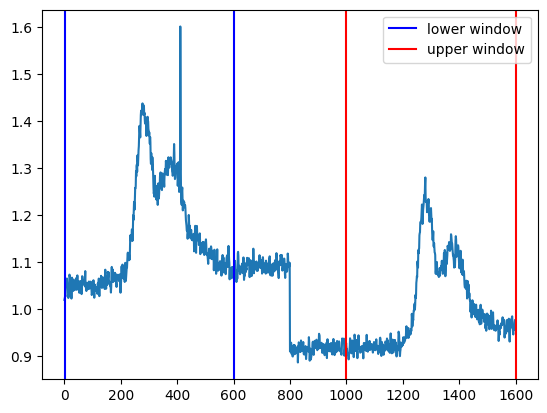

In [9]:
plt.plot(np.append(LSB, USB))
plt.axvline(li-width, color='b', label='lower window')
plt.axvline(li+width, color='b')
plt.axvline(ui-width, color='r', label='upper window')
plt.axvline(ui+width, color='r')
plt.legend()
plt.show()

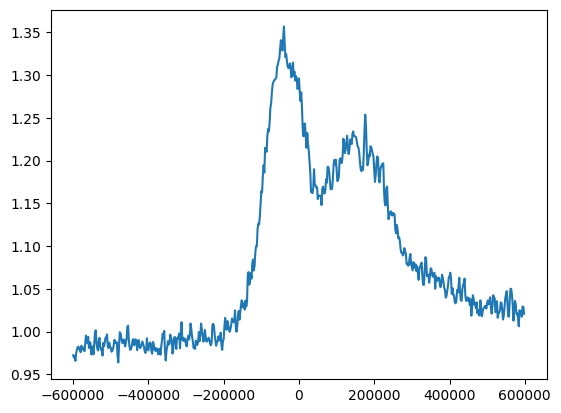

In [52]:
# average both sidebands to produce s_line
s_line = .5 * (LSB[li-width : li+width] + USB[ui-mid-width : ui-mid+width])
s_line[410] = s_line[409]
s_line[411] = s_line[412]
freqs = np.fft.fftshift(np.fft.fftfreq(len(s_line), 1/(1.2e6)))
plt.plot(freqs, s_line)

# calc G

In [53]:
T = {'cal': 300, 'cold': 10}
G_better7 = ((T['cal'] - T['cold']) / np.sum(s_cal - s_cold)) * np.sum(s_cold) 
# G_better7 = (T['cal'] - T['cold']) / (s_cal[fitband] - s_cold[fitband])
# G_better7 = (T['cal'] - T['cold']) / (s_cal[fitband] - s_cold[fitband])

# G_better7 = (T['cal'] - T['cold']) / (s_cal - s_cold)
# Trx_better7 = np.mean(G_better7 * s_cold[fitband])

# plt.plot(np.linspace(0,1,len(s_cal[fitband])), s_cal[fitband])
# plt.show()

# plt.plot(np.linspace(0, 1, len(G_better7)), G_better7)
# plt.title('estimated G')
# plt.show()
# print('mean G = ', np.mean(G_better7))

print('G:', G_better7)

G: 131.93988386202588


# Plot G

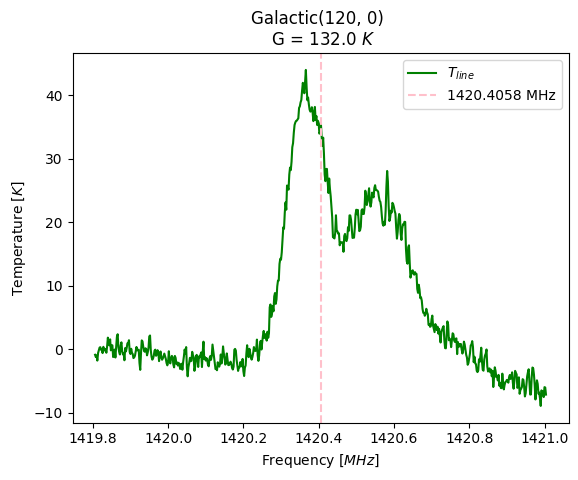

In [136]:
# s_line = np.append(LSB, USB)

# plot T_line
T_line = np.multiply(s_line, G_better7) #- Trx_better7
x = (freqs + freq_0) * 10**-6 #- 1
y = T_line
# plt.plot(x, y, color='blue', label='$T_{line}$')

# plot T_on
T_on = np.multiply(s_on, G_better7)
# plt.plot(x, T_on, color='red', label='$T_{on}$')

# plot T_off
T_off = np.multiply(s_off, G_better7)
# plt.plot(x, T_off, color='brown', label='$T_{off}$')

# plot T_line - polyfit
li2, ui2 = find_ones(freqs, bound=.2e6)
offx = np.append(x[:li2], x[ui2:])
offy = np.append(y[:li2], y[ui2:])
fit = np.polyval(np.polyfit(offx, offy, 1), x)
# plt.scatter(offx, offy)
plt.plot(x, y - fit, color='green', label='$T_{line}$')

# plt.axvline(freqs[li], color='b')
# plt.axvline(freqs[ui], color='r')

# plot 21cm line
plt.axvline(freq_0 * 10**-6, color='pink', label=str(freq_0*10**-6)+ ' MHz', linestyle='dashed')


plt.title('Galactic(120, 0) \n G = {} $K$'.format(str(np.round(G_better7))))
# plt.xlim([.5, 1.5])
plt.xlabel('Frequency [$MHz$]')
plt.ylabel('Temperature [$K$]')
plt.legend()
plt.show()

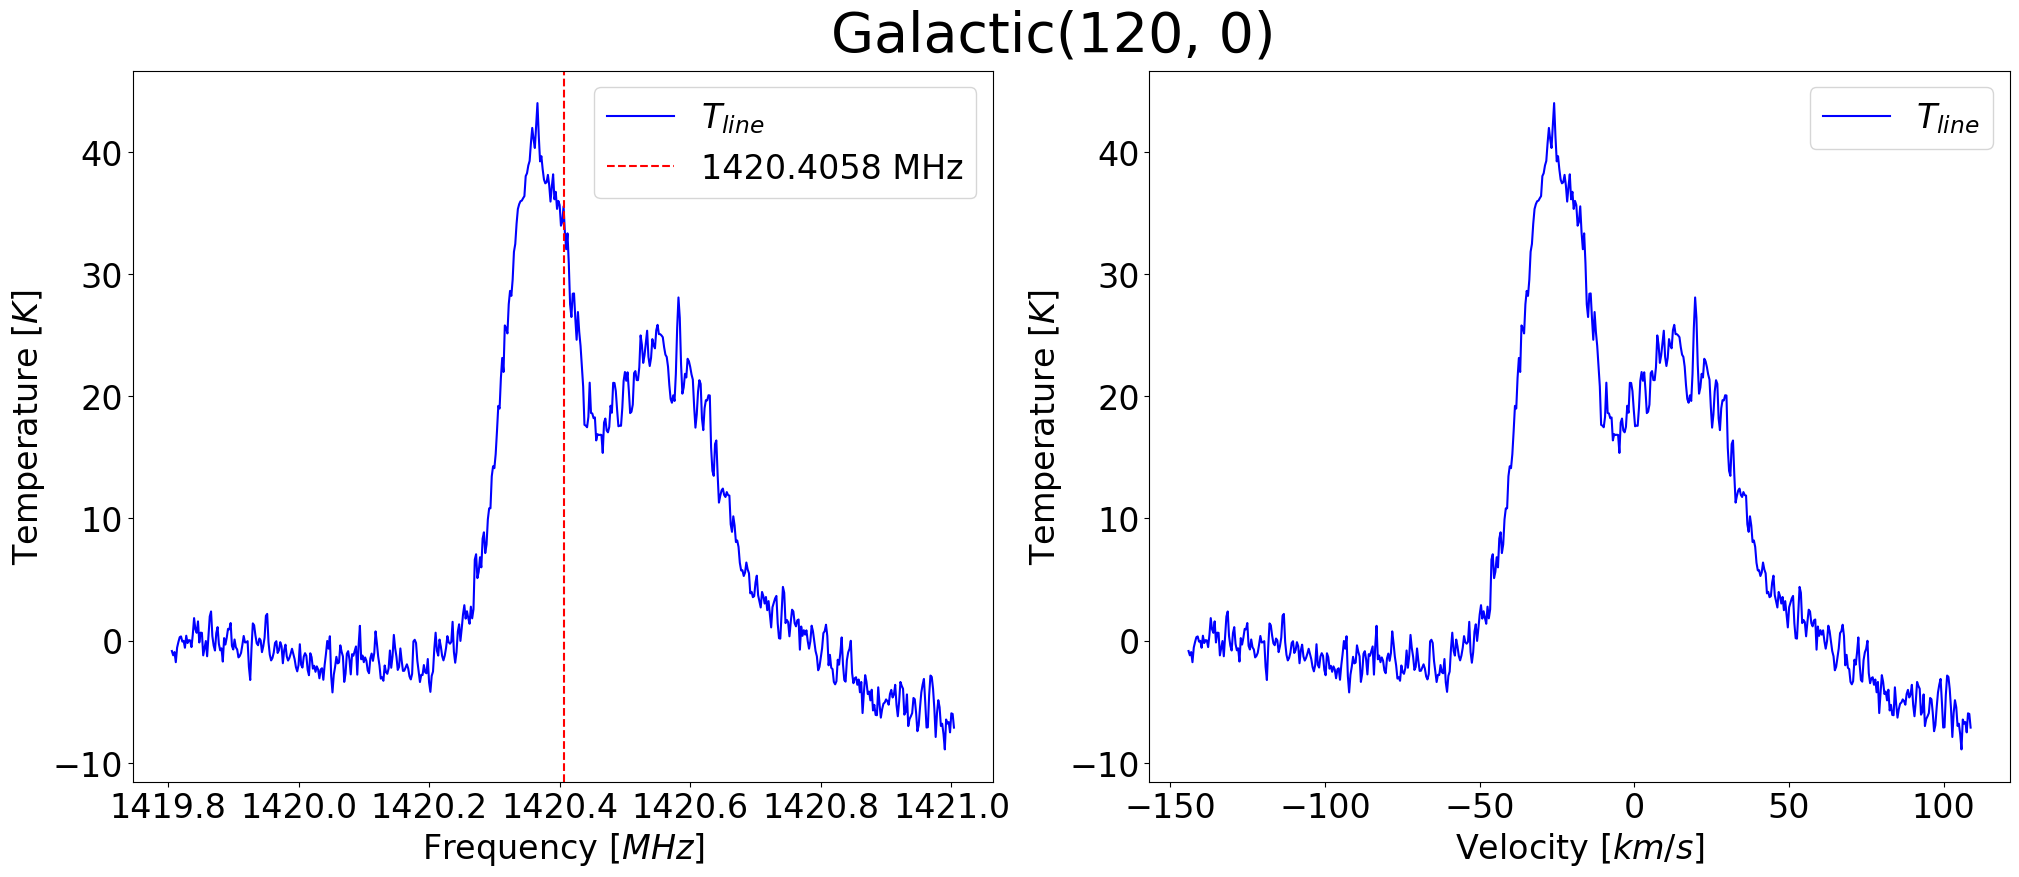

In [168]:
plt.rcParams.update({'font.size': 24})
fig, axs = plt.subplots(1, 2,  figsize=(21, 9))
fig.tight_layout(pad=2.0)
fig.suptitle('Galactic(120, 0)', fontsize=40)

plt0 = axs[0]
plt0.plot(x, y - fit, color='blue', label='$T_{line}$')
plt0.axvline(freq_0 * 10**-6, color='red', label=str(freq_0*10**-6)+ ' MHz', linestyle='dashed')
plt0.set_xlabel('Frequency [$MHz$]')
plt0.set_ylabel('Temperature [$K$]')
plt0.legend()

plt1 = axs[1]
# freq to velocity domain conversion
LSR_corr = - 17456.727  # m/s (ADJUST!!)
v_domain = - ( -(freqs + freq_0) + freq_0) * c_speed / freq_0 + LSR_corr 
plt1.plot(v_domain * 10**-3, T_line - fit, color='blue', label='$T_{line}$')
plt1.set_xlabel('Velocity [$km/s$]')
plt1.set_ylabel('Temperature [$K$]')
plt1.legend()

plt.show()

In [77]:
def chisq(Y, model, sigma, reduced=False, degree=6):
    prim = np.abs(Y - model)**2
    if reduced:
        return np.sum(prim / np.mean(prim)) / (Y.size - 6)
    else:
        return np.sum(np.abs(Y - model))**2 / sigma **2

In [130]:
T21 = T_line - fit
ans2, cov2 = ugradio.gauss.gaussfit(freqs + freq_0, T21, amp=[20,20], avg=[1420.3e6,1420.6e6], sig=[1e5,1e5], return_cov=True)
profile2 = ugradio.gauss.gaussval(freqs + freq_0, **ans2)
TSYS = np.sum([cov2[i, i] for i in range(len(cov2))])
# TSYS = np.average(ans2['sig'])
ans2

In [133]:
chisq = np.sum(np.abs(T21 - profile2)**2)
print(f'Chi-Square: {chisq}')
chisq_r = np.sum(np.abs(T21 - profile2)**2 / np.mean(np.abs(T21 - profile2)**2)) / (T21.size - 6)
print(f'Reduced Chi-Square: {chisq_r}')

Chi-Square: 3643.5509357049577
Reduced Chi-Square: 1.0101010101010102


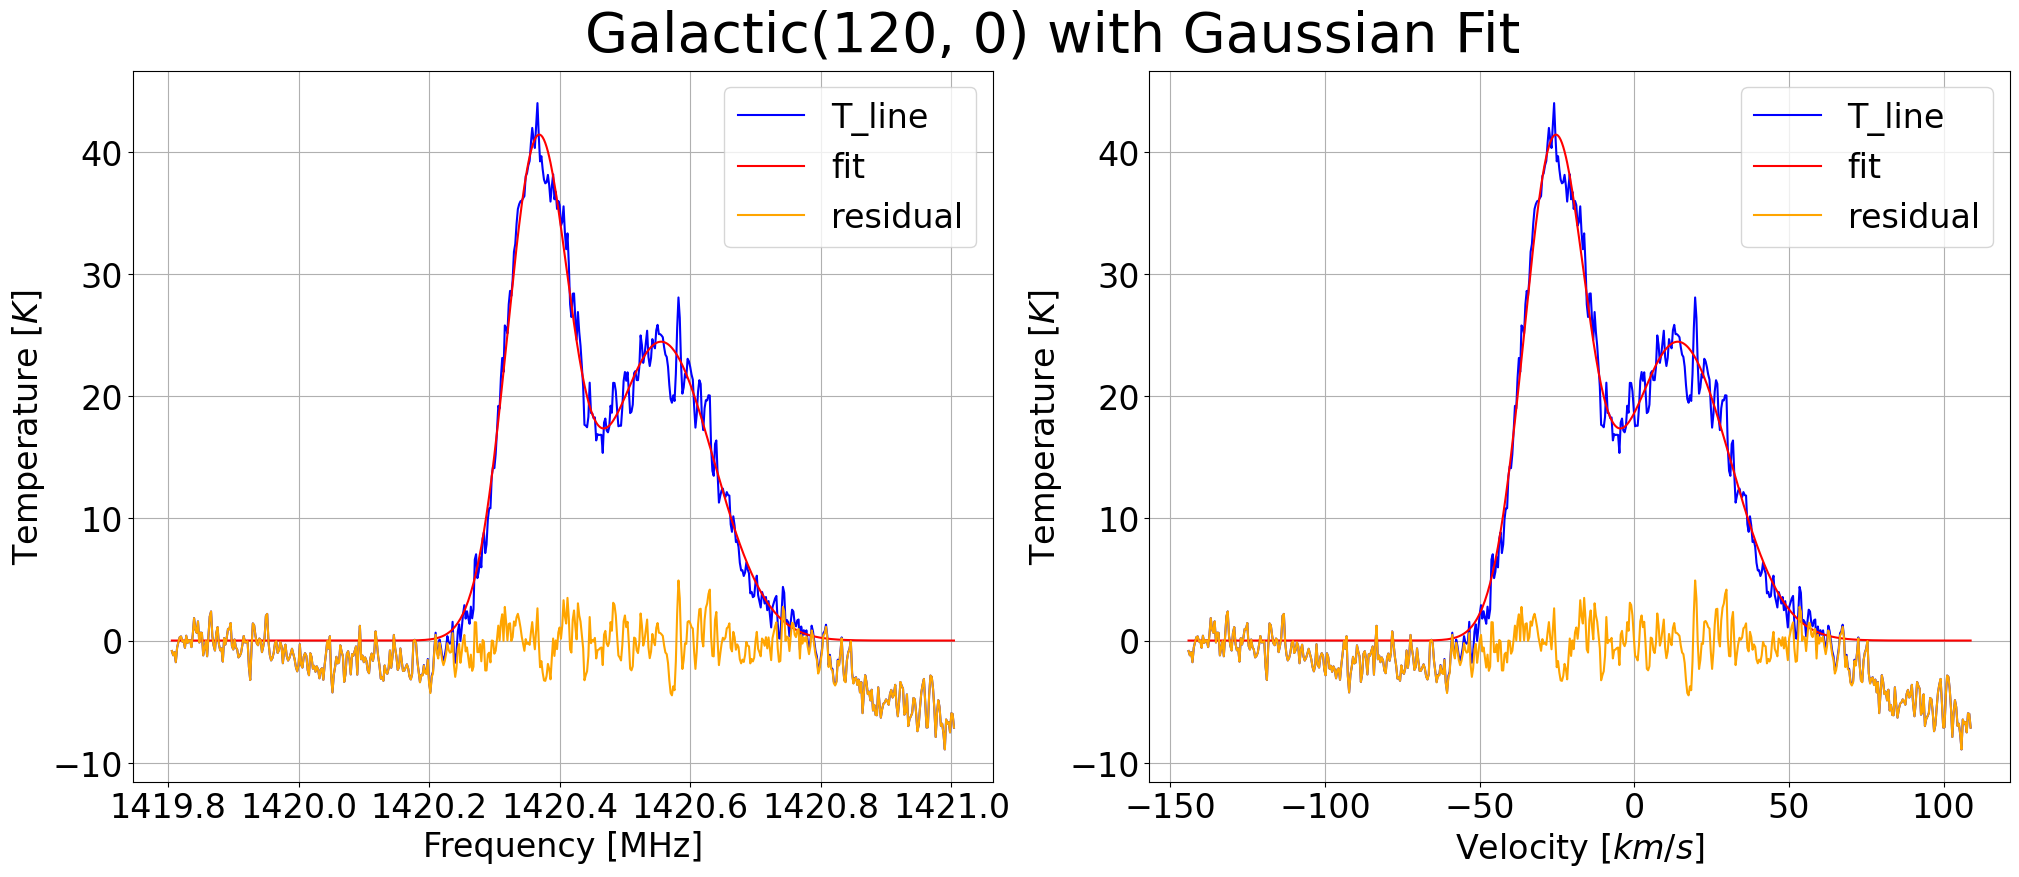

In [169]:
fig, axs = plt.subplots(1, 2,  figsize=(21, 9))
fig.tight_layout(pad=2.0)
fig.suptitle('Galactic(120, 0) with Gaussian Fit', fontsize=40)

plt0 = axs[0]
plt0.plot((freq_0 + freqs)/1e6 , T21, color='blue', label='T_line')
plt0.plot((freq_0 + freqs)/1e6, profile2, color='red', label='fit')
plt0.plot((freq_0 + freqs)/1e6, T21 - profile2, color='orange', label='residual')
plt0.set_xlabel('Frequency [MHz]')
plt0.set_ylabel('Temperature [$K$]')
plt0.legend()
_ = plt0.grid()

plt1 = axs[1]
plt1.plot(v_domain * 10**-3 , T21, color='blue', label='T_line')
plt1.plot(v_domain * 10**-3, profile2, color='red', label='fit')
plt1.plot(v_domain * 10**-3, T21 - profile2, color='orange', label='residual')
plt1.set_xlabel('Velocity [$km/s$]')
plt1.set_ylabel('Temperature [$K$]')
plt1.legend()
_ = plt1.grid()

In [153]:
xs = np.array([-2, -1, 0, 1, 2], dtype=float)
ys = np.array([-4.0761021 , -0.61376301,  0.96543424,  3.7373177 ,  3.86467818])

def chisq_min(p):
    m,b = p
    return chisq(ys, f(xs,m,b), 1.)

chi0 = chisq_min(ans2)
print(chisq_min(ans2+np.array([.32,0])) - chi0)
print(chisq_min(ans2+np.array([-.32,0])) - chi0)
print(chisq_min(ans2+np.array([0,0.45])) - chi0)
print(chisq_min(ans2+np.array([0,-0.45])) - chi0)

ValueError: too many values to unpack (expected 2)

# Velocity Domain

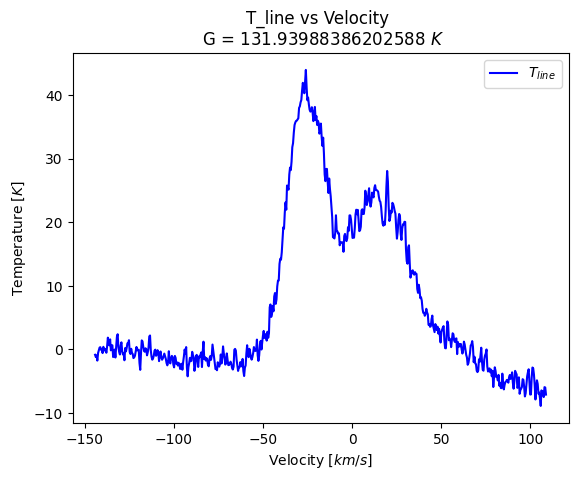

In [59]:
# freq to velocity domain conversion
LSR_corr = - 17456.727  # m/s (ADJUST!!)
v_domain = - ( -(freqs + freq_0) + freq_0) * c_speed / freq_0 + LSR_corr 

plt.plot(v_domain * 10**-3, T_line - fit, color='blue', label='$T_{line}$')
# plt.axvline(freq_0 * 10**-6, color='r', label=str(freq_0*10**-6)+ ' MHz')
plt.title('T_line vs Velocity \n G = {} $K$'.format(str(G_better7)))
# plt.xlim(-10000, 10000)
plt.xlabel('Velocity [$km/s$]')
plt.ylabel('Temperature [$K$]')
plt.legend()
plt.show()

In [170]:
def test():
    T21 = T_line - fit
    ans2, cov2 = ugradio.gauss.gaussfit(v_domain, T21, amp=[20,20], avg=[-30e3, 20e3], sig=[2e3,2e3], return_cov=True)
    profile2 = ugradio.gauss.gaussval(v_domain, **ans2)
    TSYS = np.sum([cov2[i, i] for i in range(len(cov2))])
    # TSYS = np.average(ans2['sig'])
    return ans2
test()

c:\Users\gvnin\Documents\berkeley\astro121\venv\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


{'amp': array([-1805.77748226,  -127.61425023]),
 'avg': array([ 15128282.7793178 , -18383941.32838303]),
 'sig': array([ 333619.58580581, 1341311.67888672])}